## Part Two: Classifying Community Areas by Violent Crime Total

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.target import BalancedBinningReference, ClassBalance, FeatureCorrelation
from yellowbrick.classifier import ClassificationReport

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.pipeline import Pipeline

In [25]:
total_df = pd.read_csv('/Users/Emi/Downloads/merged_df_pop.csv')
total_df.head()

,Community Area,Month,Violent Crimes,Total Crimes,Units,Grocery_Store_Count,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,...,PER CAPITA INCOME,HARDSHIP INDEX,COMMUNITY,TOTAL POPULATION,geometry,Area_sqm,Area_sqkm,Population Density (people/sqkm),Violent Crimes per Capita,Crimes per Capita
0,1.0,2003-01,141,595,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,2.273900,9.595536
1,1.0,2003-02,136,515,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,2.193265,8.305380
2,1.0,2003-03,173,669,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,2.789963,10.788930
3,1.0,2003-04,193,670,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,3.112502,10.805057
4,1.0,2003-05,201,769,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,3.241517,12.401626


In [26]:
total_df['Units per Capita'] = (total_df['Units'] / total_df['TOTAL POPULATION']) * 1000
#total_df['Percent Violent Crimes'] = (total_df['Violent Crimes per Capita'] / total_df['Crimes per Capita'])
total_df['Percent Violent Crimes'] = (total_df['Violent Crimes'] / total_df['Total Crimes'])
total_df['Percent Violent Crimes'].describe()

count    19469.000000
mean         0.279552
std          0.075393
min          0.019608
25%          0.226415
50%          0.280600
75%          0.333333
max          0.600000
Name: Percent Violent Crimes, dtype: float64

In [27]:
def create_classes(data, variable):
    p25 = np.percentile(data['Percent Violent Crimes'], 25)
    p50 = np.percentile(total_df['Percent Violent Crimes'], 50)
    p75 = np.percentile(total_df['Percent Violent Crimes'], 75)

    classes = np.select(
        [total_df['Percent Violent Crimes'] > p75, (total_df['Percent Violent Crimes'] > p50) & (total_df['Percent Violent Crimes'] <= p75), (total_df['Percent Violent Crimes'] > p25) & (total_df['Percent Violent Crimes'] <= p50)],
        ['Above 75th Percentile', 'Between 50th and 75th Percentile', 'Between 25th and 50th Percentile'],
        default='Below 25th Percentile'
    )

    return classes

# Create classes for your variable
total_df['MultiClass Target'] = create_classes(total_df, 'Percent Violent Crimes')

In [28]:
total_df['MultiClass Target'].value_counts()

Between 50th and 75th Percentile    5011
Below 25th Percentile               4873
Between 25th and 50th Percentile    4862
Above 75th Percentile               4723
Name: MultiClass Target, dtype: int64

#### Can we classify community areas based on whether violent crime repesents more or less than 28% (mean) of total crimes?

In [29]:
def categorize_crimes(Percent_Violent_Crimes):
    if Percent_Violent_Crimes >= 0.279552:
        return '>0.28%'
    elif Percent_Violent_Crimes < 0.279552:
        return '<0.28%'

total_df['Binary Target'] = total_df['Percent Violent Crimes'].apply(categorize_crimes)

total_df['Binary Target'].value_counts()

>0.28%    9844
<0.28%    9625
Name: Binary Target, dtype: int64

In [30]:
total_df.rename(columns={'Month':'Date'},inplace=True)

total_df['year'] = total_df['Date'].str.slice(0, 4)
total_df['Month'] = total_df['Date'].str.slice(-2)

total_df.columns

Index(['Community Area', 'Date', 'Violent Crimes', 'Total Crimes', 'Units',
       'Grocery_Store_Count', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'COMMUNITY', 'TOTAL POPULATION', 'geometry',
       'Area_sqm', 'Area_sqkm', 'Population Density (people/sqkm)',
       'Violent Crimes per Capita', 'Crimes per Capita', 'Units per Capita',
       'Percent Violent Crimes', 'MultiClass Target', 'Binary Target', 'year',
       'Month'],
      dtype='object')

In [31]:
total_df['Month'] = total_df['Month'].astype('int')

In [32]:
#Creating a season feature by mapping months to seasons
total_df['season'] = total_df['Month'].apply(lambda x: 'spring' 
                                            if 3 <= x <= 5 
                                            else ('summer' if 6 <= x <= 8 
                                            else ('fall' if 9 <= x <= 11 
                                            else 'winter')))

In [33]:
total_df.describe()

,Community Area,Violent Crimes,Total Crimes,Units,Grocery_Store_Count,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,...,HARDSHIP INDEX,TOTAL POPULATION,Area_sqm,Area_sqkm,Population Density (people/sqkm),Violent Crimes per Capita,Crimes per Capita,Units per Capita,Percent Violent Crimes,Month
count,19469.000000,19469.000000,19469.000000,16443.000000,18964.000000,19469.00000,19469.000000,19469.000000,19469.000000,19469.000000,...,19469.000000,19469.000000,1.946900e+04,19469.000000,19469.000000,19469.000000,19469.000000,16443.000000,19469.000000,19469.000000
mean,39.003698,103.324413,359.599979,439.025725,6.749736,4.92525,21.772315,15.375058,20.347666,35.745221,...,49.520314,37614.875186,1.400845e+07,14.008450,3004.193739,2.996198,10.123933,15.582597,0.279552,6.481021
std,22.223973,102.807630,329.711169,484.504368,5.161660,3.65911,11.450362,7.493388,11.746227,7.281718,...,28.498520,23077.408229,9.148943e+06,9.148943,1542.366253,2.508885,7.141743,22.535349,0.075393,3.461018
min,1.000000,1.000000,5.000000,23.000000,1.000000,0.30000,3.300000,4.700000,2.500000,13.500000,...,1.000000,3527.000000,2.831664e+06,2.831664,221.392726,0.028713,0.133412,0.478962,0.019608,1.000000
25%,20.000000,32.000000,127.000000,100.000000,3.000000,2.30000,13.200000,9.200000,11.800000,32.000000,...,25.000000,20551.000000,8.340905e+06,8.340905,1943.324387,1.177214,4.789625,3.530534,0.226415,3.000000
50%,39.000000,68.000000,246.000000,262.000000,5.000000,3.80000,18.900000,13.900000,18.500000,38.100000,...,50.000000,33447.000000,1.328866e+07,13.288661,2682.407869,2.021953,7.811554,6.402157,0.280600,6.000000
75%,58.000000,144.000000,507.000000,583.000000,10.000000,6.80000,29.200000,20.000000,26.600000,40.500000,...,74.000000,50228.000000,1.655848e+07,16.558483,3858.817213,4.209610,13.592491,18.126693,0.333333,9.000000
max,77.000000,873.000000,3740.000000,2327.000000,22.000000,15.80000,56.500000,35.900000,54.800000,51.500000,...,98.000000,99890.000000,6.254948e+07,62.549480,7416.637136,18.816800,58.973632,131.024282,0.600000,12.000000


In [34]:
total_df.isnull().sum()

Community Area                                     0
Date                                               0
Violent Crimes                                     0
Total Crimes                                       0
Units                                           3026
Grocery_Store_Count                              505
PERCENT OF HOUSING CROWDED                         0
PERCENT HOUSEHOLDS BELOW POVERTY                   0
PERCENT AGED 16+ UNEMPLOYED                        0
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA       0
PERCENT AGED UNDER 18 OR OVER 64                   0
PER CAPITA INCOME                                  0
HARDSHIP INDEX                                     0
COMMUNITY                                          0
TOTAL POPULATION                                   0
geometry                                           0
Area_sqm                                           0
Area_sqkm                                          0
Population Density (people/sqkm)              

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(total_df[['Grocery_Store_Count']])
total_df['Grocery_Store_Count'] = imputer.transform(total_df[['Grocery_Store_Count']])

imputer.fit(total_df[['Units']])
total_df['Units'] = imputer.transform(total_df[['Units']])
total_df['Units per Capita'] = imputer.transform(total_df[['Units per Capita']])
total_df.isnull().sum()

Community Area                                  0
Date                                            0
Violent Crimes                                  0
Total Crimes                                    0
Units                                           0
Grocery_Store_Count                             0
PERCENT OF HOUSING CROWDED                      0
PERCENT HOUSEHOLDS BELOW POVERTY                0
PERCENT AGED 16+ UNEMPLOYED                     0
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    0
PERCENT AGED UNDER 18 OR OVER 64                0
PER CAPITA INCOME                               0
HARDSHIP INDEX                                  0
COMMUNITY                                       0
TOTAL POPULATION                                0
geometry                                        0
Area_sqm                                        0
Area_sqkm                                       0
Population Density (people/sqkm)                0
Violent Crimes per Capita                       0


In [36]:
X = total_df[['Units per Capita','Grocery_Store_Count', 'PERCENT OF HOUSING CROWDED',
'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
'HARDSHIP INDEX','year', 'Month', 'season']]

y = total_df['Binary Target']
ym = total_df['MultiClass Target']

In [37]:
#Preprocessing
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
ym = label_encoder.fit_transform(ym)

X = pd.get_dummies(X, columns=['season'])
X['year'] = X['year'].astype('category')

label_encoder = LabelEncoder()
X['Year_LabelEncoded'] = label_encoder.fit_transform(X['year'])

X = X.drop(columns='year')

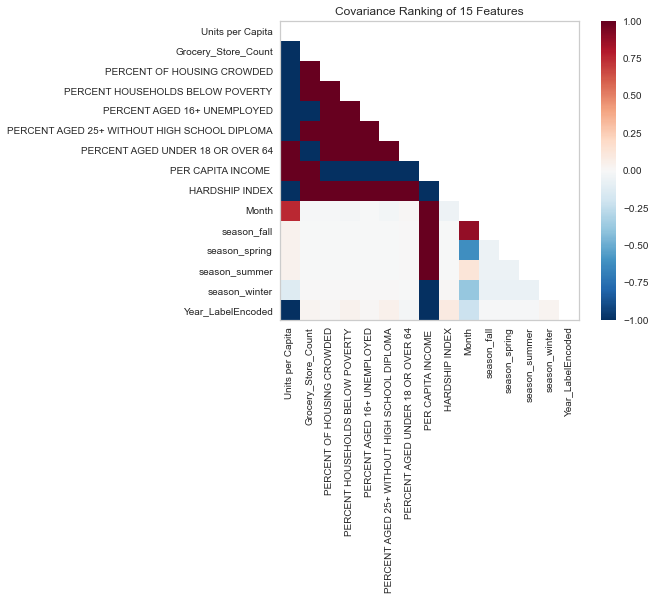

<AxesSubplot:title={'center':'Covariance Ranking of 15 Features'}>

In [38]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='covariance')

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

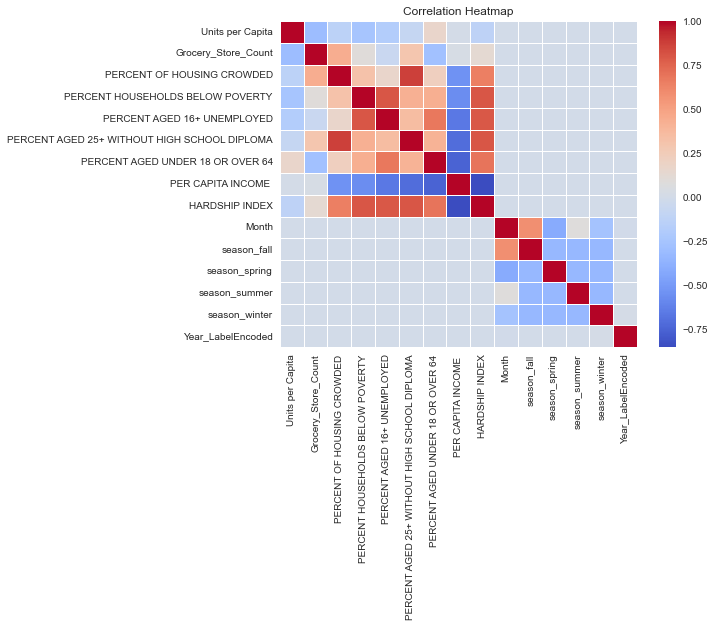

In [39]:
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f", linewidths=.8)

# Show the plot
plt.title("Correlation Heatmap")
plt.show()

In [40]:
#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X, ym, test_size=0.2,random_state=42)

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train['Units per Capita Scaled'] = scaler.fit_transform(X_train[['Units per Capita']])
Xm_train['Units per Capita Scaled'] = scaler.fit_transform(Xm_train[['Units per Capita']])
#X_train['Population Density Scaled'] = scaler.fit_transform(X_train[['Population Density (people/sqkm)']])

X_train = X_train.drop(columns=['Units per Capita'])
Xm_train = Xm_train.drop(columns=['Units per Capita'])
#,'Population Density (people/sqkm)'])

X_test['Units per Capita Scaled'] = scaler.fit_transform(X_test[['Units per Capita']])
Xm_test['Units per Capita Scaled'] = scaler.fit_transform(Xm_test[['Units per Capita']])
#X_test['Population Density Scaled'] = scaler.fit_transform(X_test[['Population Density (people/sqkm)']])

X_test = X_test.drop(columns=['Units per Capita']) 
Xm_test = Xm_test.drop(columns=['Units per Capita']) 
#,'Population Density (people/sqkm)'])

In [42]:
def score_model(X_train, y_train, X_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    
    model = Pipeline([
         ('estimator', estimator)
    ])

    # Train the model on the training set
    model.fit(X_train, y_train, **kwargs)  
    
    # Predict on the testing set
    y_test_predicted = model.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    f1 = f1_score(y_test, y_test_predicted)
    print("{}: {}".format(estimator.__class__.__name__, f1))

In [45]:
def multiclass_score_model(X_train, y_train, X_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    
    model = Pipeline([
         ('estimator', estimator)
    ])

    # Train the model on the training set
    model.fit(X_train, y_train, **kwargs)  
    
    # Predict on the testing set
    y_test_predicted = model.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    f1 = f1_score(y_test, y_test_predicted, average='weighted')
    print("{}: {}".format(estimator.__class__.__name__, f1))

In [43]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(max_iter=10000), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_train, y_train, X_test, y_test, model)

SVC: 0.8446797781139687
NuSVC: 0.8426626323751891
LinearSVC: 0.6725754218510313
SGDClassifier: 0.22604856512141278
KNeighborsClassifier: 0.8326612903225806
LogisticRegression: 0.799186578546009
LogisticRegressionCV: 0.7990714469950992
BaggingClassifier: 0.8129198966408269
ExtraTreesClassifier: 0.8059701492537313
RandomForestClassifier: 0.8149457207775814


In [47]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(max_iter=10000), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    multiclass_score_model(Xm_train, ym_train, Xm_test, ym_test, model)

SVC: 0.5844999594712694
NuSVC: 0.5823273137309141
LinearSVC: 0.32791336970522983
SGDClassifier: 0.09972280222442188
KNeighborsClassifier: 0.5591366717628723
LogisticRegression: 0.4733857492156412
LogisticRegressionCV: 0.5056553662720095
BaggingClassifier: 0.5505368352141151
ExtraTreesClassifier: 0.5291992952892802
RandomForestClassifier: 0.5423922945220573


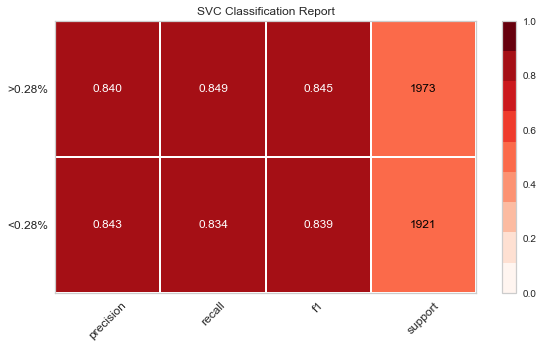

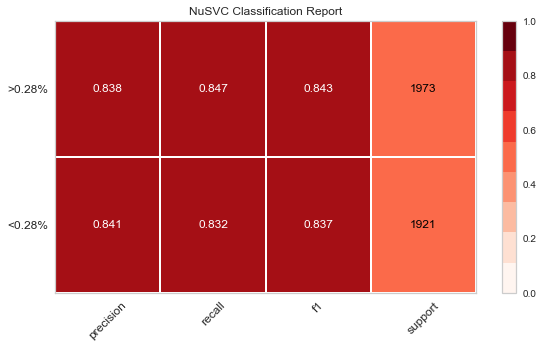

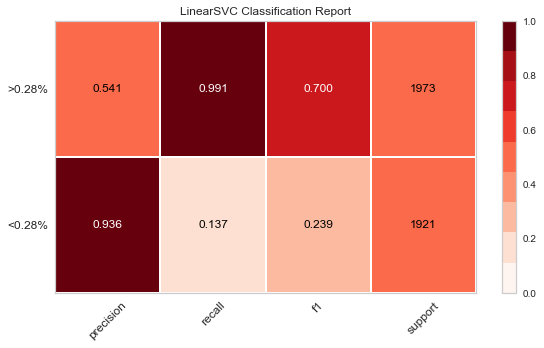

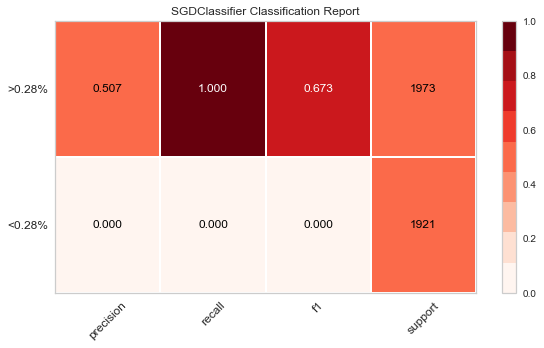

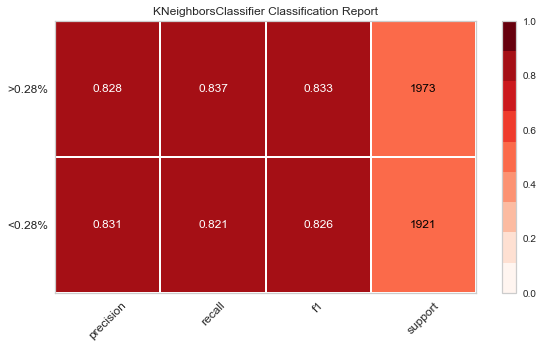

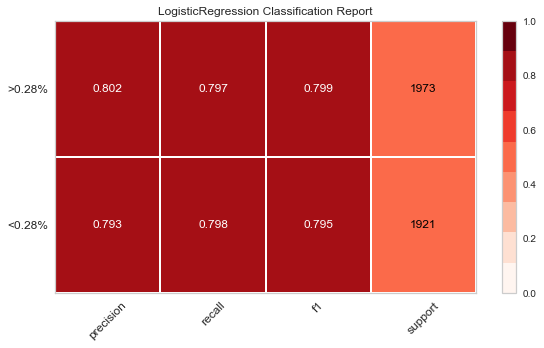

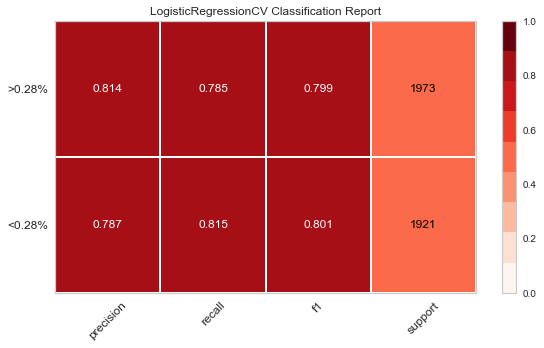

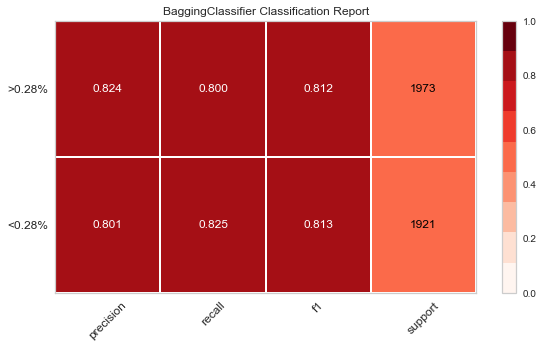

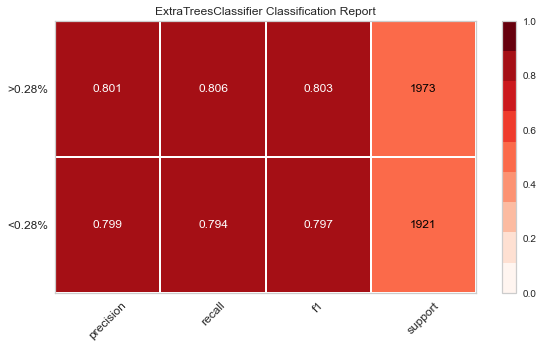

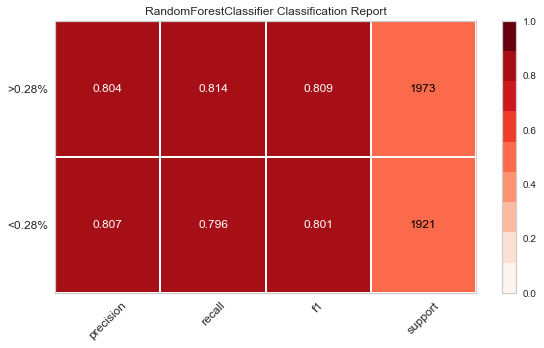

In [48]:
def visualize_model(X_train, y_train, X_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    
    model = Pipeline([
         ('estimator', estimator)
    ])

    # Train the model on the training set
    model.fit(X_train, y_train, **kwargs)  
    
    # Predict on the testing set
    y_test_predicted = model.predict(X_test)

    # Display classification report
    report = classification_report(y_test, y_test_predicted, target_names=['<0.28%','>0.28%'])
    #print(report)

    # Visualize the classification report
    visualizer = ClassificationReport(
        model,
        classes=['<0.28%','>0.28%'],
        cmap="Reds",
        support=True,
        size=(600, 360)
    )
    visualizer.score(X_test, y_test)
    visualizer.show()

for model in models:
    visualize_model(X_train, y_train, X_test, y_test, model)

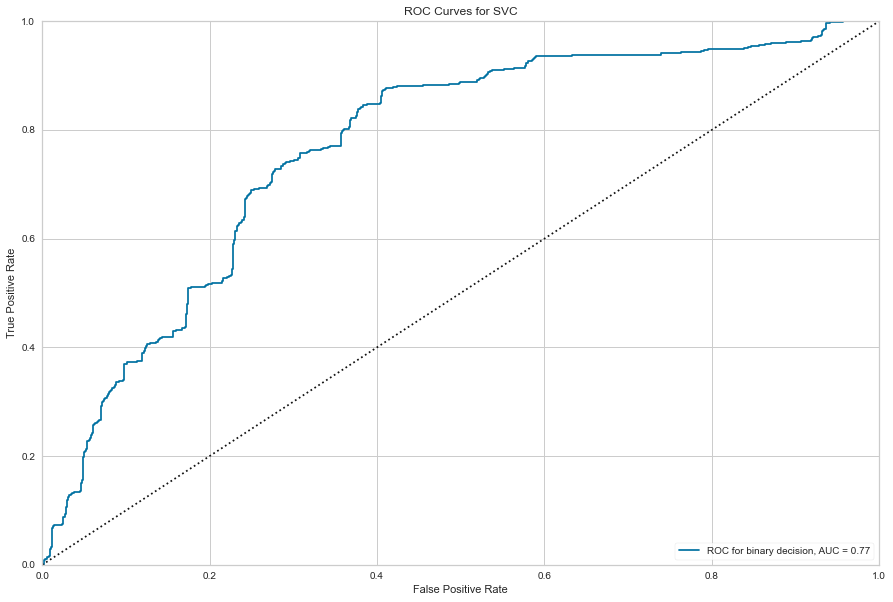

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [49]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(SVC(),binary=True, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()      

In [50]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

model = ElasticNet()
model.fit(X, y)
print(list(zip(X.columns, model.coef_.tolist())))

[('Units per Capita', -0.00021406318413229943), ('Grocery_Store_Count', 0.0), ('PERCENT OF HOUSING CROWDED', -0.0), ('PERCENT HOUSEHOLDS BELOW POVERTY', 0.004549467561822151), ('PERCENT AGED 16+ UNEMPLOYED', 0.005498505548285777), ('PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', -0.0), ('PERCENT AGED UNDER 18 OR OVER 64', 0.0), ('PER CAPITA INCOME ', -7.527370715463421e-06), ('HARDSHIP INDEX', 0.0023508120950694322), ('Month', 0.0), ('season_fall', -0.0), ('season_spring', 0.0), ('season_summer', 0.0), ('season_winter', -0.0), ('Year_LabelEncoded', 0.0)]


In [51]:
model = Ridge()
model.fit(X, y)
print(list(zip(X.columns, model.coef_.tolist())))

[('Units per Capita', -0.00010378450331206555), ('Grocery_Store_Count', 0.010649314420759805), ('PERCENT OF HOUSING CROWDED', -0.009208768078268379), ('PERCENT HOUSEHOLDS BELOW POVERTY', 0.00038676404498527456), ('PERCENT AGED 16+ UNEMPLOYED', 0.012771906743768673), ('PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', -0.01158648481081359), ('PERCENT AGED UNDER 18 OR OVER 64', 0.0004104106463802722), ('PER CAPITA INCOME ', -5.068383088670703e-06), ('HARDSHIP INDEX', 0.008259500239964145), ('Month', 0.0013097113825893626), ('season_fall', -0.013812824341909825), ('season_spring', 0.03691274439297124), ('season_summer', 0.04061014139403865), ('season_winter', -0.06371006143883541), ('Year_LabelEncoded', 0.013601350924568566)]


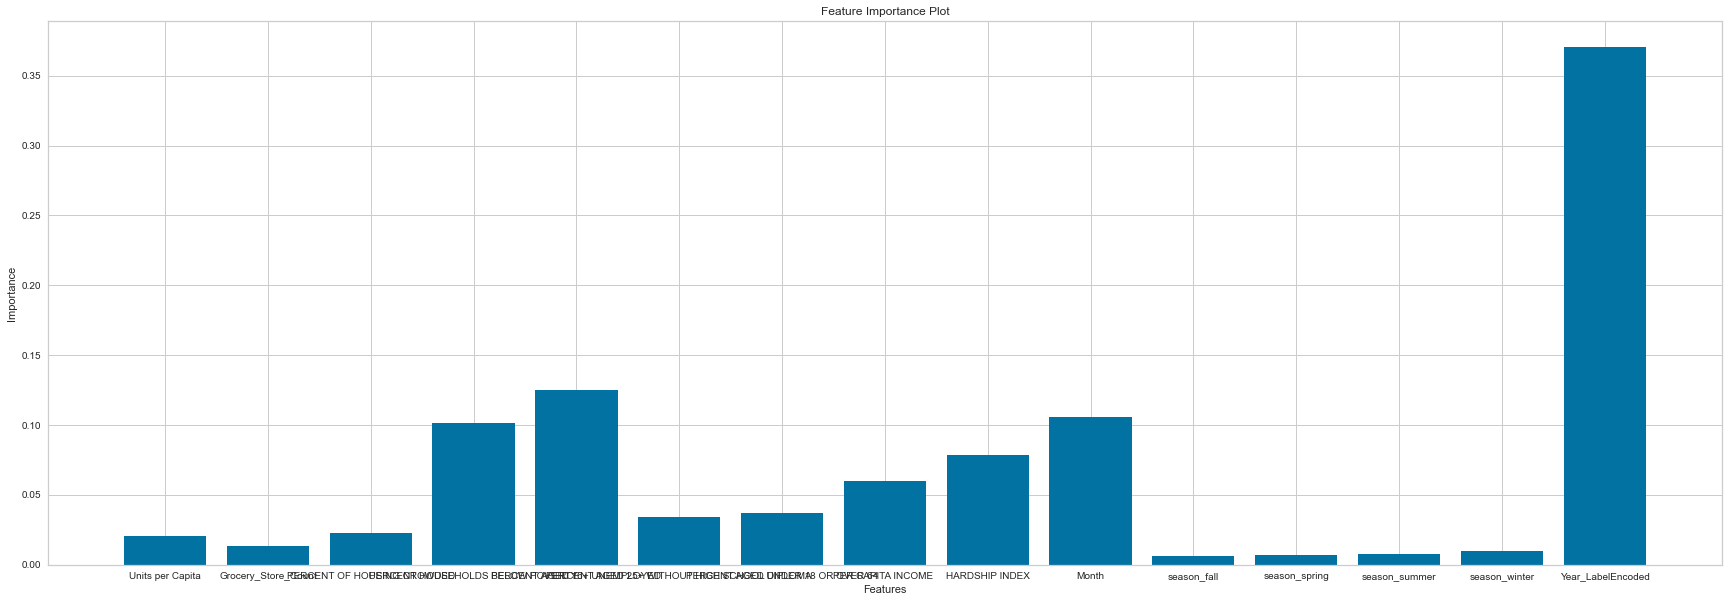

In [52]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a bar plot for feature importances
plt.figure(figsize=(30,10))
plt.bar(X.columns, feature_importances)
plt.title("Feature Importance Plot")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()